In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys; sys.path.append('..')

In [ ]:
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from feature_extraction.nearest_key_lookup import NearestKeyLookup
from feature_extraction.nearest_key_lookup_optimized import NearestKeyLookup as NearestKeyLookupOptimized
from ns_tokenizers import ALL_CYRILLIC_LETTERS_ALPHABET_ORD
from ns_tokenizers import KeyboardTokenizerv1

In [3]:
allowed_keys = ALL_CYRILLIC_LETTERS_ALPHABET_ORD

with open('../data/data_separated_grid/gridname_to_grid.json', encoding='utf-8') as f:
    gridname_to_grid = json.load(f)
grid_before_fix = gridname_to_grid['default']

with open('../data/data_separated_grid/gridname_to_grid__fixed.json', encoding='utf-8') as f:
    gridname_to_grid__fixed = json.load(f)
grid = gridname_to_grid__fixed['default']


nkl_old_grid = NearestKeyLookup(grid = grid_before_fix, nearest_key_candidates = allowed_keys)
nkl = NearestKeyLookup(grid = grid, nearest_key_candidates = allowed_keys)


In [4]:
nkl_optimized = NearestKeyLookupOptimized(grid = grid, allowed_keys = allowed_keys)

In [5]:
nkl_optimized.mean_widths

[98.18181818181819, 98.18181818181819, 93.55555555555556]

In [6]:
len(nkl_optimized.nearest_key_labels_dict)

9032

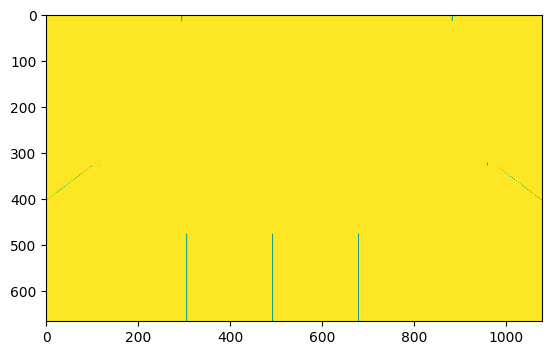

In [7]:
# We can see that the difference between the `coord_to_kb_label` 
# for both grids are not identical, but very similar. 
# The fixed one should be slighly more accurate. We will only use it
# from now on. 
plt.imshow(nkl.coord_to_kb_label.T == nkl_old_grid.coord_to_kb_label.T)

In [8]:
del nkl_old_grid

In [9]:
failed_input_to_values__analytical = {}
failed_input_to_values__via_map = {}

for x in tqdm(range(grid['width'])):
    for y in range(grid['height']):
        nkl_result = nkl.get_nearest_kb_label(x, y)
        _, is_correctness_guaranteed = nkl_optimized._get_nearest_kb_key_label_analytically(x, y)
        result = nkl_optimized.get_nearest_kb_key_label(x, y)
        if nkl_result == result:
            continue
        failed_input_dict = (failed_input_to_values__analytical 
                             if is_correctness_guaranteed 
                             else failed_input_to_values__via_map)
        failed_input_dict[(x, y)] = (nkl_result, result)

all_failed_inputs_dict = {**failed_input_to_values__analytical, **failed_input_to_values__via_map}

100%|██████████| 1080/1080 [00:09<00:00, 109.73it/s]


In [10]:
len(failed_input_to_values__analytical)
# 2822

2822

In [11]:
len(failed_input_to_values__via_map)

618

In [12]:
len(all_failed_inputs_dict) / grid['width'] / grid['height'] * 100 

0.477539008273641

In [13]:
nkl_optimized.get_nearest_kb_key_label(0, 334)

'ф'

In [14]:
# grid

In [15]:
nkl_optimized.rows

[['й', 'ц', 'у', 'к', 'е', 'н', 'г', 'ш', 'щ', 'з', 'х'],
 ['ф', 'ы', 'в', 'а', 'п', 'р', 'о', 'л', 'д', 'ж', 'э'],
 ['я', 'ч', 'с', 'м', 'и', 'т', 'ь', 'б', 'ю']]

In [16]:
nkl_optimized.keyboard_y_offset

15

In [17]:
optimized_results = np.array([nkl_optimized.get_nearest_kb_key_label(x, y) for x in range(grid['width']) for y in range(grid['height'])]).reshape(grid['width'], grid['height'])

In [18]:
non_optimized_results = np.array([nkl.get_nearest_kb_label(x, y) for x in range(grid['width']) for y in range(grid['height'])]).reshape(grid['width'], grid['height'])

In [19]:
non_optimized_results = non_optimized_results.T

In [20]:
optimized_results = optimized_results.T

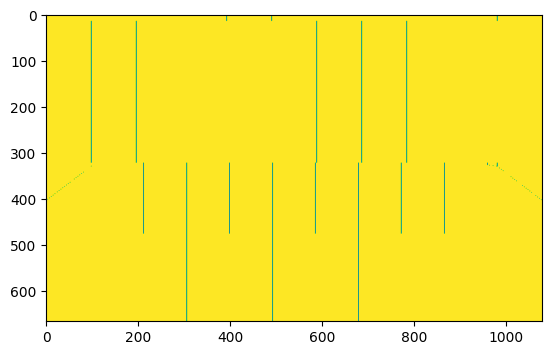

In [21]:
plt.imshow(optimized_results == non_optimized_results)

In [22]:
keyboard_tokenizer = KeyboardTokenizerv1()

In [23]:
# apply keyboard_tokenizer.get_token(token_id) to optimized_results array

optimized_results_int = np.vectorize(keyboard_tokenizer.get_token)(optimized_results)
non_optimized_results_int = np.vectorize(keyboard_tokenizer.get_token)(non_optimized_results)

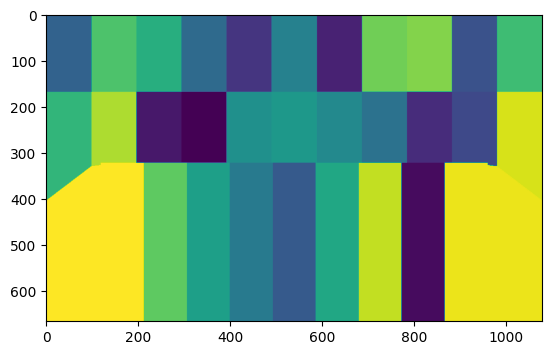

In [24]:
plt.imshow(optimized_results_int)

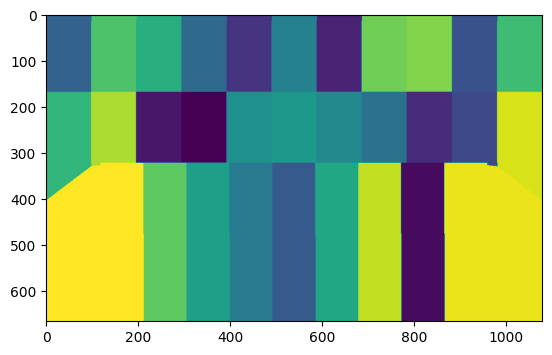

In [25]:
plt.imshow(non_optimized_results_int)

In [26]:
nkl_optimized.save_state('nkl_optimized_state.pkl')

In [27]:
nkl_optimized = NearestKeyLookupOptimized.from_state_dict('nkl_optimized_state.pkl')

In [28]:
nkl.save_state('nkl_state.pkl')

In [29]:
nkl = NearestKeyLookup.from_state_dict('nkl_state.pkl')